In [1]:
import numpy as np
from PIL import Image
import matplotlib as plt

In [2]:
def load_and_scale_images(image_path, watermark_path):
    image = Image.open(image_path).convert('L')  
    image = image.resize((512, 512))
    
    image_array = np.array(image)
    
    watermark = Image.open(watermark_path).convert('L')
    watermark = watermark.resize((32, 32))
    watermark_array = np.array(watermark) > 128
    watermark = Image.fromarray(watermark_array)
    
    return image_array, watermark_array, image, watermark

In [3]:
image_array,watermark_array,input_image, watermark_image=load_and_scale_images('lena.png','watermark.png')

In [4]:
def shuffle_watermark_image(watermark_image):
    np.random.seed(42)

    wm_img_array = np.array(watermark_image) 
    shape = wm_img_array.shape

    wm_img_array = wm_img_array.flatten()

    indices = np.arange(wm_img_array.size)
    i_n = np.random.permutation(indices)

    shuffled_img_array = wm_img_array[i_n]

    shuffled_image_array = shuffled_img_array.reshape(shape)
    shuffled_image = Image.fromarray(shuffled_image_array)

    return shuffled_image, i_n

In [5]:
shuffled_watermark, indices = shuffle_watermark_image(watermark_image)

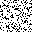

In [6]:
shuffled_watermark

In [7]:
np.array(shuffled_watermark)

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True, False,  True, ..., False,  True, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False,  True]])

In [8]:
def split_image_into_four(image):

    width, height = image.size

    mid_width = width // 2
    mid_height = height // 2

    ftl = image.crop((0, 0, mid_width, mid_height))  
    ftr = image.crop((mid_width, 0, width, mid_height))  
    fbl = image.crop((0, mid_height, mid_width, height)) 
    fbr = image.crop((mid_width, mid_height, width, height))

    return ftl, ftr, fbl, fbr

In [9]:
def merge_image_from_four(ftl, ftr, fbl, fbr):
    width, height = ftl.size
    
    merged_image = Image.new('L', (width * 2, height * 2))

    merged_image.paste(ftl, (0, 0))  
    merged_image.paste(ftr, (width, 0)) 
    merged_image.paste(fbl, (0, height))  
    merged_image.paste(fbr, (width, height))

    return merged_image

In [10]:
import bisect

def find_interval(sorted_array, x):
    index = bisect.bisect_right(sorted_array, x)
    if index == 0:
        return 0
    return index

In [11]:
def reconstruct_image(blocks, original_indices, block_size):
    reconstruct_image = np.zeros((512 // 2, 512 // 2))
    for (U, D, Vt), (i,j) in zip(blocks, original_indices):
        print(D[0])
        D_matrix = np.diag(D)
        r_b = np.dot(U, np.dot(D_matrix, Vt))
        reconstruct_image[i:i+block_size,j: j+block_size] = r_b
    return reconstruct_image

In [12]:
d_large = []
d_high = []
d_low = []
d_new = []
def watermark_embedding_in_d_matrix(ftl, wm, block_size=8):
    global d_large, d_low, d_high, d_new
    original_indices = []
    wm_array = np.array(wm) 
    wm_array = wm_array.flatten().astype('uint64')
    ftl_arr = np.array(ftl)
    #d_large = []
    blocks = []
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            d_large.append(D[0])
            original_indices.append((i,j))
            blocks.append((U, D, V))

    print(len(blocks) == wm_array.size)
    T = 60
    d_max = max(d_large)
    d_min = min(d_large)
    d_low = np.linspace(d_min - T, d_max)
    d_high = np.linspace(d_min, d_max + T)


    bit_idx = 0
    for d in d_large:
        i = find_interval(d_high, d)
        dlow = d_low[i]
        dhigh = d_high[i]
        print(f'Watermark bit {wm_array[bit_idx]}')
        print(f'Donja granica {dlow}')
        print(f'Gornja granica {dhigh}')
        print(f'Singularna vrednosti{d}')
        print('-------------------')
        if wm_array[bit_idx] == 1:
            blocks[bit_idx][1][0] = (dlow + (dhigh + dlow)/2)/2
            print('if')
        else:
            blocks[bit_idx][1][0] = (dhigh + (dhigh + dlow)/2)/2
            print('else')
        d_new.append(blocks[bit_idx][1][0])
        bit_idx += 1

    #print(original_indices)
    result = reconstruct_image(blocks, original_indices, 8)
    return result

In [13]:
def watermak_embedding(image, wm):
    ftl, ftr, fbl, fbr = split_image_into_four(input_image)
    
    ftl_new = watermark_embedding_in_d_matrix(ftl, wm)
    ftl_new = Image.fromarray(ftl_new)
    ftl_new.show()
    
    #fbr_new = watermark_embedding_in_u_matrix(fbr, wm)
    #fbr_new = Image.fromarray(fbr_new).convert('L')
    #fbr_new.show()
    
    merged_image = merge_image_from_four(ftl_new, ftr, fbl, fbr)
    merged_image.show()
    merged_image.save('watermarked_image.png')
    
    return merged_image

In [14]:
ftl, ftr, fbl, fbr = split_image_into_four(input_image)

In [15]:
watermarked_image = watermak_embedding(input_image, shuffled_watermark)

True
Watermark bit 1
Donja granica 1189.15180149349
Gornja granica 1249.15180149349
Singularna vrednosti1247.176713135579
-------------------
if
Watermark bit 1
Donja granica 1189.15180149349
Gornja granica 1249.15180149349
Singularna vrednosti1222.5745041384198
-------------------
if
Watermark bit 1
Donja granica 1158.163060863273
Gornja granica 1218.163060863273
Singularna vrednosti1202.9747339094827
-------------------
if
Watermark bit 1
Donja granica 1158.163060863273
Gornja granica 1218.163060863273
Singularna vrednosti1192.6924352767394
-------------------
if
Watermark bit 0
Donja granica 1220.1405421237073
Gornja granica 1280.1405421237073
Singularna vrednosti1251.3532119233605
-------------------
else
Watermark bit 0
Donja granica 1313.1067640143592
Gornja granica 1373.1067640143592
Singularna vrednosti1349.1694167138544
-------------------
else
Watermark bit 1
Donja granica 1251.1292827539246
Gornja granica 1311.1292827539246
Singularna vrednosti1299.4905797444794
------------

In [16]:
ftl_new, _, _, _ = split_image_into_four(watermarked_image)

In [17]:
np.array(ftl_new) == np.array(ftl)

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [18]:
min(d_large)

195.5346200661027

In [19]:
max(d_large)

1653.9829109467491

In [20]:
d_high

array([ 195.53462007,  226.5233607 ,  257.51210133,  288.50084196,
        319.48958259,  350.47832322,  381.46706385,  412.45580448,
        443.44454511,  474.43328574,  505.42202637,  536.410767  ,
        567.39950763,  598.38824826,  629.37698889,  660.36572952,
        691.35447015,  722.34321078,  753.33195141,  784.32069204,
        815.30943267,  846.2981733 ,  877.28691393,  908.27565456,
        939.26439519,  970.25313582, 1001.24187645, 1032.23061708,
       1063.21935771, 1094.20809834, 1125.19683897, 1156.1855796 ,
       1187.17432023, 1218.16306086, 1249.15180149, 1280.14054212,
       1311.12928275, 1342.11802338, 1373.10676401, 1404.09550464,
       1435.08424527, 1466.07298591, 1497.06172654, 1528.05046717,
       1559.0392078 , 1590.02794843, 1621.01668906, 1652.00542969,
       1682.99417032, 1713.98291095])

In [21]:
d_low

array([ 135.53462007,  166.5233607 ,  197.51210133,  228.50084196,
        259.48958259,  290.47832322,  321.46706385,  352.45580448,
        383.44454511,  414.43328574,  445.42202637,  476.410767  ,
        507.39950763,  538.38824826,  569.37698889,  600.36572952,
        631.35447015,  662.34321078,  693.33195141,  724.32069204,
        755.30943267,  786.2981733 ,  817.28691393,  848.27565456,
        879.26439519,  910.25313582,  941.24187645,  972.23061708,
       1003.21935771, 1034.20809834, 1065.19683897, 1096.1855796 ,
       1127.17432023, 1158.16306086, 1189.15180149, 1220.14054212,
       1251.12928275, 1282.11802338, 1313.10676401, 1344.09550464,
       1375.08424527, 1406.07298591, 1437.06172654, 1468.05046717,
       1499.0392078 , 1530.02794843, 1561.01668906, 1592.00542969,
       1622.99417032, 1653.98291095])

In [22]:
d_new

[1204.15180149349,
 1204.15180149349,
 1173.163060863273,
 1173.163060863273,
 1265.1405421237073,
 1358.1067640143592,
 1266.1292827539246,
 925.2531358215346,
 615.3657295193618,
 677.3432107797963,
 738.3319514100136,
 708.3319514100136,
 739.3206920402309,
 801.2981733006654,
 893.2756545611,
 955.2531358215346,
 986.2418764517519,
 956.2418764517519,
 955.2531358215346,
 956.2418764517519,
 987.2306170819691,
 987.2306170819691,
 956.2418764517519,
 986.2418764517519,
 956.2418764517519,
 956.2418764517519,
 986.2418764517519,
 925.2531358215346,
 956.2418764517519,
 956.2418764517519,
 956.2418764517519,
 986.2418764517519,
 1204.15180149349,
 1173.163060863273,
 1173.163060863273,
 1173.163060863273,
 1266.1292827539246,
 1297.118023384142,
 1204.15180149349,
 924.2643951913172,
 584.3769888891445,
 677.3432107797963,
 708.3319514100136,
 708.3319514100136,
 708.3319514100136,
 831.2981733006654,
 863.2756545611,
 894.2643951913172,
 925.2531358215346,
 925.2531358215346,
 956.2

In [23]:
d_large

[1247.176713135579,
 1222.5745041384198,
 1202.9747339094827,
 1192.6924352767394,
 1251.3532119233605,
 1349.1694167138544,
 1299.4905797444794,
 941.9015590238773,
 634.2352149297346,
 720.400139168784,
 740.092190602891,
 743.8050659439003,
 756.9550272330824,
 828.2376773913068,
 897.8029040443936,
 940.1559844360252,
 972.2118656505934,
 977.0630153030194,
 964.2156154847036,
 982.1886441096643,
 1005.1753051440404,
 1007.9416397358566,
 997.8316269884413,
 994.7983423740438,
 999.20094274353,
 999.8226609683392,
 992.9433575584256,
 965.0572722194996,
 986.6473648238767,
 970.7112645313458,
 993.1664263048694,
 982.6003947838689,
 1218.420639321202,
 1213.897714882143,
 1207.8987229352656,
 1203.7002978022842,
 1293.843907697833,
 1326.3015708611897,
 1245.7914755309798,
 911.3518397806922,
 607.9150581054142,
 698.5166164679881,
 747.302050527405,
 729.0308325605532,
 733.4620684199886,
 817.0959178345196,
 894.3285165398985,
 936.8512871039028,
 955.7684065144882,
 969.05698163

In [24]:
def extract_watermark_from_d_matrix(ftl, watermark_size=(32, 32), block_size=8):
    
    ftl_arr = np.array(ftl, dtype='uint64')

    extraxted_watermark = []
    
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)

            d = D[0]
            print(d)
            idx = find_interval(d_high, d)
            dh = d_high[idx]
            dl = d_low[idx]
            print(f'dhigh {dh}')
            print(f'dlow {dl}')
            print('-----------')

            if  d < ((dl+dh)/2):
                extraxted_watermark.append(1)
                print('if')
            else:
                extraxted_watermark.append(0)
                print('else')
    extraxted_watermark_result = np.array(extraxted_watermark).reshape((32,32))
    return extraxted_watermark_result

In [25]:
res = extract_watermark_from_d_matrix(ftl_new)

1199.1837861520783
dhigh 1218.163060863273
dlow 1158.163060863273
-----------
else
1198.5785054775702
dhigh 1218.163060863273
dlow 1158.163060863273
-----------
else
1170.9774708369212
dhigh 1187.1743202330556
dlow 1127.1743202330556
-----------
else
1168.6938169013274
dhigh 1187.1743202330556
dlow 1127.1743202330556
-----------
else
1259.3477978660576
dhigh 1280.1405421237073
dlow 1220.1405421237073
-----------
else
1357.1684188547085
dhigh 1373.1067640143592
dlow 1313.1067640143592
-----------
else
1261.648852661885
dhigh 1280.1405421237073
dlow 1220.1405421237073
-----------
else
921.2345308265445
dhigh 939.2643951913172
dlow 879.2643951913172
-----------
else
610.2593162710618
dhigh 629.3769888891445
dlow 569.3769888891445
-----------
else
672.6638580652592
dhigh 691.3544701495791
dlow 631.3544701495791
-----------
else
732.0945634356118
dhigh 753.3319514100136
dlow 693.3319514100136
-----------
else
703.822339824763
dhigh 722.3432107797963
dlow 662.3432107797963
-----------
else
7

In [26]:
res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])